<a href="https://colab.research.google.com/github/nicole-hjlin/mpala-tree-mapping/blob/main/geomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoMap

Matching location data of .las files (LiDAR) with specific tree IDs and ForestGeo Tree Species Labels.

In [1]:
!pip3 install lasio laspy
!pip3 install utm
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Mount Google Drive (where data sit)
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Set Project Folder
import os
header = '/content/drive/My Drive'
hongjin_path = 'classes/2022 fall/CS 288 AI for Social Impact/CS288 Final Project - Tree Species'
derek_path = 'jr/CS288 Final Project - Tree Species'
matt_path = ''

# Select path from above
project_path = os.path.join(header, hongjin_path)
project_path

'/content/drive/My Drive/classes/2022 fall/CS 288 AI for Social Impact/CS288 Final Project - Tree Species'

In [5]:
# Import code utilities files
import sys
sys.path.insert(0, os.path.join(project_path, 'mpala-tree-mapping'))

In [70]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from osgeo import gdal
import laspy
import utm
import pickle
import geopandas
import geopy.distance

## Convert location data to lat and long

### ForestGEO Labels

In [88]:
# read data
forestgeo = pd.read_csv(os.path.join(project_path, 'PlotDataReport10-07-2022_1734418034.txt'), delimiter = "\t")
forestgeo.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive


In [112]:
# keep records with location data 
r_remove = sum((forestgeo['PX'].isna()) & (forestgeo['PY'].isna()))/len(forestgeo)*100
print('Removing {}% records with missing location data. '.format(r_remove)) 
forestgeo = forestgeo[(~forestgeo['PX'].isna()) & (~forestgeo['PY'].isna())]

Removing 2.2284298537635827% records with missing location data. 


256330.0472
35684.7414
Northwest corner post:  (0.322613787883293, 36.81070166797714)


,id,left,top,right,bottom,Quadrat,geometry
0,1.0,256330.0472,35684.7414,256350.0472,35664.7414,101,"POLYGON ((262689.296 31846.312, 262707.340 318..."
1,2.0,256330.0472,35664.7414,256350.0472,35644.7414,102,"POLYGON ((262697.923 31828.268, 262715.967 318..."
2,3.0,256330.0472,35644.7414,256350.0472,35624.7414,103,"POLYGON ((262706.549 31810.224, 262724.593 318..."
3,4.0,256330.0472,35624.7414,256350.0472,35604.7414,104,"POLYGON ((262715.176 31792.180, 262733.220 318..."
4,5.0,256330.0472,35604.7414,256350.0472,35584.7414,105,"POLYGON ((262723.802 31774.136, 262741.846 317..."


In [10]:
# 2022-11-02: adding Tyler's approximation of the northwest corner post
forestgeo_grid = geopandas.read_file(os.path.join(project_path, 'ForestGEO_Grid', 'ForestGEO_Grid.shp'))
nw_corner_latlong = utm.to_latlon(min(forestgeo_grid['left']), max(forestgeo_grid['top']), 37, 'N')
print(min(forestgeo_grid['left']))
print(max(forestgeo_grid['top']))
print(nw_corner_latlong)
forestgeo_grid.head()

Northwest:  (0.322613787883293, 36.81070166797714)
Southwest:  (0.31809345666931366, 36.81070262773725)
Northeast:  (0.3226184346004927, 36.83225450753058)
Southeast:  (0.3180980382650492, 36.83225545786032)


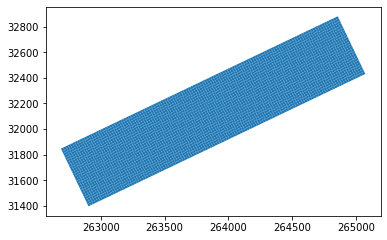

In [27]:
forestgeo_grid.plot()
plt.show()

In [115]:
# convert location data PX and PY to lat and long for data matching
## cite: https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters

def forestgeo_to_latlong(origin_latlong, south_dis_meters, east_dis_meters):
  """
  local helper function
  returns the lat and long of a geo point knowing the base point coordinates in lat and long and distance from the base point in meters due south and east
  
  parameters: 
  origin_latlong: (lat, long)
  south_dis_meters: distance from the original point due south in meters
  east_dis_meters: distance from the original point due east in meters

  returns:
  new_lat: float
    latitude of the new geo point
  new_long: float
    longitude of the new geo point
  """
  origin = geopy.Point(origin_latlong)
  # south. distance PY. bearing due south is 180
  new_lat = geopy.distance.geodesic(meters=south_dis_meters).destination(origin, 180).latitude 
  # east. distance PX. bearing due east is 90
  new_long = geopy.distance.geodesic(meters=east_dis_meters).destination(origin, 90).longitude 
  return new_lat, new_long

In [116]:
# test local function for calculating new geo point
## the output should approximate the northwest point of the 102 quadrat
new_latlong = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = 20, east_dis_meters = 0)
utm.from_latlon(new_latlong[0], new_latlong[1])

,id,left,top,right,bottom,Quadrat,geometry
1,2.0,256330.0472,35664.7414,256350.0472,35644.7414,102,"POLYGON ((262697.923 31828.268, 262715.967 318..."


In [117]:
# test local function for calculating new geo point
## the output should approximate the northwest point of the 103 quadrat
new_latlong = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = 40, east_dis_meters = 0)
utm.from_latlon(new_latlong[0], new_latlong[1])

,id,left,top,right,bottom,Quadrat,geometry
25,101.0,256350.0472,35684.7414,256370.0472,35664.7414,201,"POLYGON ((262707.340 31854.938, 262725.384 318..."


In [119]:
# convert location data px and py to lat and long
new_lat_lst = []
new_long_lst = []
for i in range(len(forestgeo)):
  new_lat, new_long = forestgeo_to_latlong(nw_corner_latlong, south_dis_meters = forestgeo.iloc[i].PY, east_dis_meters = forestgeo.iloc[i].PX)
  new_lat_lst.append(new_lat)
  new_long_lst.append(new_long)
forestgeo['latitude'] = new_lat_lst
forestgeo['longitude'] = new_long_lst
forestgeo.head()  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


In [154]:
# verify if approximation is within the quadrat
i = 1234
sample = forestgeo.iloc[i]
new_point = utm.from_latlon(sample.latitude, sample.longitude)
new_lat = new_point[0]
new_long = new_point[1]
grid = forestgeo_grid[forestgeo_grid.Quadrat == sample.Quadrat]
print((grid.left.values[0] <= new_lat) and (new_lat <= grid.right.values[0]))
print((grid.bottom.values[0] <= new_long) and (new_long <= grid.top.values[0]))

#utm.from_latlon(sample.latitude, sample.longitude)[0]

True
True


In [120]:
# save new data table for fast processing later
with open(os.path.join(project_path, 'outputs', 'forestgeo_with_latlong.pickle'), 'wb') as f:
    pickle.dump(forestgeo, f, protocol=pickle.HIGHEST_PROTOCOL)

In [121]:
# read saved data table with approximated lat and long
with open(os.path.join(project_path, 'outputs', 'forestgeo_with_latlong.pickle'), 'rb') as f:
    forestgeo = pickle.load(f)
forestgeo.head()

,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


### LiDAR Images

In [30]:
# Data Paths
lidar_path = os.path.join(project_path, 'MpalaForestGEOPlotData', 'data')
high_res_path = os.path.join(lidar_path, 'HighResAcquisitions')
# segmented tree images
tree_files = os.listdir(os.path.join(lidar_path, 'HighResAcquisitions', 'MpalaForestGEO_LasClippedtoTreePolygons'))
tree_files[:5]

['treeID_42693.las',
 'treeID_42718.las',
 'treeID_42716.las',
 'treeID_42730.las',
 'treeID_42715.las']

In [34]:
sample_tree = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', 'treeID_42693.las'))
print(list(sample_tree.point_format.dimension_names)) 
sample_tree.X

43709


array([26282792, 26282791, 26282967, ..., 26282580, 26282598, 26282593],
      dtype=int32)

In [32]:
# convert LiDAR location data to lat long coordinates
## Mpala coordinates: 1.0822850033164138, 37.149144200529584
## cite https://github.com/Turbo87/utm
## UTM zone system: https://www.usgs.gov/faqs/how-are-utm-coordinates-measured-usgs-topographic-maps#:~:text=The%20UTM%20(Universal%20Transverse%20Mercator,Zone%2019%2C%20which%20includes%20Maine.

# get the zone number and zone letter from Mpala's coordinates
utm.from_latlon(1.0822850033164138, 37.149144200529584)

(294046.54747902136, 119688.00302557605, 37, 'N')

In [ ]:
# sample tree point lat longs 
scaleX = sample_tree.header.scale[0]
scaleY = sample_tree.header.scale[1]
print(scaleX)
print(scaleY)
sample_latlong = utm.to_latlon(sample_tree.X*scaleX, sample_tree.Y*scaleY, 37, 'N')
# approximate the location of the tree by taking the average of the points 
print(np.average(sample_latlong, axis = 1))

(array([0.28432283, 0.28432481, 0.28433702, ..., 0.2843334 , 0.28433394,
       0.28433376]), array([36.86906305, 36.86906296, 36.86907876, ..., 36.86904401,
       36.86904563, 36.86904518]))
[ 0.28433333 36.86906439]


In [ ]:
%timeit
# generate the lat and long of points for each tree and save outputs for downstream matching

latlong_dict = {}
for i, t in enumerate(tree_files):
  print(f'{i}/{len(tree_files)}', end='\r')
  # read las file 
  las = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', t))
  scaleX = las.header.scale[0]
  scaleY = las.header.scale[1]
  latlongs = utm.to_latlon(las.X*scaleX, las.Y*scaleY, 37, 'N')
  latlongs_avg = np.average(latlongs, axis = 1)
  latlong_dict[t[:-4]] = latlongs, latlongs_avg

# save new data table for fast processing later
with open(os.path.join(project_path, 'outputs', 'lidar_with_latlong.pickle'), 'wb') as f:
    pickle.dump(latlong_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

KeyboardInterrupt: ignored

^ stopped early because it is taking a long time. We should verify a few samples before conversion with the full dataset.

In [ ]:
len(latlong_dict)

9473

In [ ]:
# save new data table for fast processing later
with open(os.path.join(project_path, 'outputs', 'lidar_with_latlong.pickle'), 'wb') as f:
    pickle.dump(latlong_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [155]:
# read saved data table with approximated lat and long
with open(os.path.join(project_path, 'outputs', 'lidar_with_latlong.pickle'), 'rb') as f:
    latlong_dict = pickle.load(f)

In [156]:
lat_lst = []
long_lst = []
for tree_id in latlong_dict.keys():
  lat_lst.append(latlong_dict[tree_id][1][0])
  long_lst.append(latlong_dict[tree_id][1][1])

tree_dict = pd.DataFrame()
tree_dict['tree_id'] = latlong_dict.keys()
tree_dict['latitude'] = lat_lst
tree_dict['longitude'] = long_lst
tree_dict.head()

,tree_id,latitude,longitude
0,treeID_42693,0.284333,36.869064
1,treeID_42718,0.284321,36.871805
2,treeID_42716,0.284316,36.870929
3,treeID_42730,0.284316,36.871608
4,treeID_42715,0.284332,36.870756


In [157]:
len(tree_dict)

2087

## Match species labels with LiDAR images

In [158]:
forestgeo.head()

,No.,Latin,Mnemonic,SubSpecies,Quadrat,PX,PY,TreeID,Tag,StemID,StemTag,Census,DBH,HOM,Date,Codes,Stem,Status,latitude,longitude
0,1,Acacia brevispica,ACACBR,NaN,221,36.30040,400.50461,124386,20847,254971,020847,1,77.0,0.5,2012-11-20,NaN,main,alive,0.318992,36.811028
1,2,Acacia brevispica,ACACBR,NaN,311,51.84520,206.57974,124814,30407,255478,030407,1,37.0,0.5,2012-11-17,NaN,main,alive,0.320746,36.811167
2,3,Acacia brevispica,ACACBR,NaN,503,81.23257,58.41180,126361,50086,257294,050086,1,50.0,0.5,2012-11-23,NaN,main,alive,0.322086,36.811431
3,4,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262757,1000015,1,23.0,0.5,2014-11-15,M,main,alive,0.322528,36.828512
4,5,Acacia brevispica,ACACBR,NaN,10001,1982.57861,9.46110,131025,1000015,262758,1000016,1,23.0,0.5,2014-11-15,NaN,NaN,alive,0.322528,36.828512


In [159]:
tree_dict.head()

,tree_id,latitude,longitude
0,treeID_42693,0.284333,36.869064
1,treeID_42718,0.284321,36.871805
2,treeID_42716,0.284316,36.870929
3,treeID_42730,0.284316,36.871608
4,treeID_42715,0.284332,36.870756


In [161]:
# initial matching attempt
match_digit = 4
tree_dict['latitude_short'] = tree_dict['latitude'].round(match_digit)
tree_dict['longitude_short'] = tree_dict['longitude'].round(match_digit)
forestgeo['latitude_short'] = forestgeo['latitude'].round(match_digit)
forestgeo['longitude_short'] = forestgeo['longitude'].round(match_digit)

pd.merge(forestgeo[forestgeo['Stem'] == 'main'][['TreeID', 'Latin', 'latitude_short', 'longitude_short']], tree_dict[['tree_id', 'latitude_short', 'longitude_short']], how='inner', on = ['latitude_short', 'longitude_short'])

,TreeID,Latin,latitude_short,longitude_short,tree_id


2022-11-03 matching unsuccessful
1. check overlap of geo grid of the two datasets
2. check sample tree

Check geo boundraies of the two datasets

In [26]:
print(min(tree_dict.latitude_short))
print(max(tree_dict.latitude_short))
print(min(tree_dict.longitude_short))
print(max(tree_dict.longitude_short))

0.2834
0.2852
36.8685
36.8736


In [27]:
print(min(forestgeo.latitude))
print(max(forestgeo.latitude))
print(min(forestgeo.longitude))
print(max(forestgeo.longitude))

0.31809216077487606
0.3226136297995587
36.81070208767665
36.83226061800827


In [11]:
lidar_grid = geopandas.read_file(os.path.join(project_path, 'MpalaForestGEOPlotData', 'data', 'HighResAcquisitions', 'MpalaForestGEO_Shapefile050mCanopySegmentation', 'MpalaForestGEO_InitialCanopySegmentation_050m.shp'))

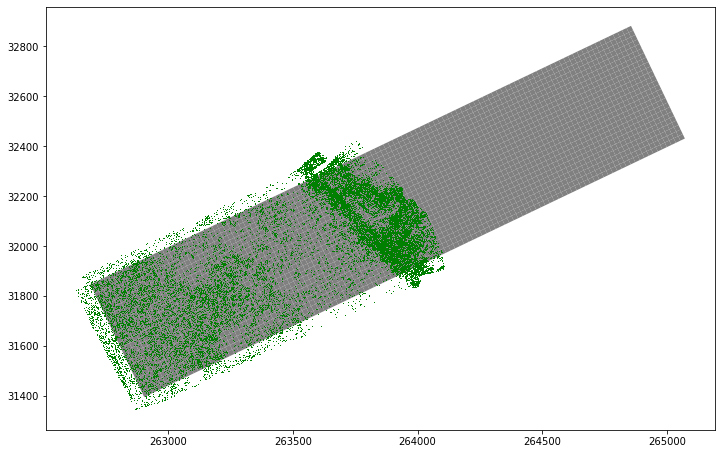

In [16]:
# plot overlap
ax = forestgeo_grid.plot(color ='grey', figsize = (12,12))
lidar_grid.plot(ax=ax, color = 'green')
plt.show()

In [20]:
forestgeo.head()

,height,winRads,treeID,crownAr,crwnDmt,geometry,centroid_x,centroid_y
0,1.057,0.9171,1,0.25,0.564190,"POLYGON ((263740.500 32423.500, 263741.000 324...",263740.75,32423.25
1,0.557,0.7671,2,0.25,0.564190,"POLYGON ((263751.000 32422.000, 263751.500 324...",263751.25,32421.75
2,1.521,1.0563,3,1.00,1.128379,"POLYGON ((263750.500 32420.000, 263750.500 324...",263750.50,32420.25
3,0.698,0.8094,4,0.50,0.797885,"POLYGON ((263754.000 32419.000, 263754.500 324...",263754.50,32418.75
4,1.037,0.9111,5,1.25,1.261566,"POLYGON ((263755.500 32418.000, 263755.500 324...",263755.25,32418.25


In [25]:
lidar_grid['latlong'] = [utm.to_latlon(lidar_grid['centroid_x'][i], lidar_grid['centroid_y'][i], 37, 'N') for i in range(len(lidar_grid))]
lidar_grid['latitude'] = [latlong[0] for latlong in lidar_grid['latlong']] 
lidar_grid['longitude'] = [latlong[1] for latlong in lidar_grid['latlong']] 
lidar_grid.head()

,height,winRads,treeID,crownAr,crwnDmt,geometry,centroid_x,centroid_y,latlong,latitude,longitude
0,1.057,0.9171,1,0.25,0.564190,"POLYGON ((263740.500 32423.500, 263741.000 324...",263740.75,32423.25,"(0.29314064654798244, 36.87725919781366)",0.293141,36.877259
1,0.557,0.7671,2,0.25,0.564190,"POLYGON ((263751.000 32422.000, 263751.500 324...",263751.25,32421.75,"(0.2931271029546435, 36.87735349725643)",0.293127,36.877353
2,1.521,1.0563,3,1.00,1.128379,"POLYGON ((263750.500 32420.000, 263750.500 324...",263750.50,32420.25,"(0.29311354007691165, 36.877346764318574)",0.293114,36.877347
3,0.698,0.8094,4,0.50,0.797885,"POLYGON ((263754.000 32419.000, 263754.500 324...",263754.50,32418.75,"(0.29309998534031406, 36.87738268949815)",0.293100,36.877383
4,1.037,0.9111,5,1.25,1.261566,"POLYGON ((263755.500 32418.000, 263755.500 324...",263755.25,32418.25,"(0.29309546609487025, 36.877389425841876)",0.293095,36.877389


In [26]:
# matching attempt
match_digit = 4
lidar_grid['latitude_short'] = lidar_grid['latitude'].round(match_digit)
lidar_grid['longitude_short'] = lidar_grid['longitude'].round(match_digit)
forestgeo['latitude_short'] = forestgeo['latitude'].round(match_digit)
forestgeo['longitude_short'] = forestgeo['longitude'].round(match_digit)

pd.merge(forestgeo[forestgeo['Stem'] == 'main'][['TreeID', 'Latin', 'latitude_short', 'longitude_short']], lidar_grid[['treeID', 'latitude_short', 'longitude_short']], how='inner', on = ['latitude_short', 'longitude_short'])

,TreeID,Latin,latitude_short,longitude_short,treeID


In [31]:
print(min(forestgeo.latitude_short))
print(max(forestgeo.latitude_short))
print(min(forestgeo.longitude_short))
print(max(forestgeo.longitude_short))

0.31809216077487606
0.3226136297995587
36.81070208767665
36.83226061800827


In [33]:
print(min(lidar_grid.latitude))
print(max(lidar_grid.latitude))
print(min(lidar_grid.longitude))
print(max(lidar_grid.longitude))

0.28335676347362343
0.29314064654798244
36.867309699135554
36.8805739304556


In [37]:
sample_tree = laspy.read(os.path.join(high_res_path, 'MpalaForestGEO_LasClippedtoTreePolygons', 'treeID_1.las'))
print(list(sample_tree.point_format.dimension_names)) 
sample_tree.X[:5]

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'HeightAboveGround']


array([26374078, 26374055, 26374095], dtype=int32)

In [38]:
sample_tree.Y[:5]

array([3242315, 3242305, 3242304], dtype=int32)

In [ ]:
forestgeo_grid.sort_values(['top'], ascending = False)

,id,left,top,right,bottom,Quadrat,geometry
0,1.0,256330.0472,35684.7414,256350.0472,35664.7414,101,"POLYGON ((262689.296 31846.312, 262707.340 318..."
850,3401.0,257010.0472,35684.7414,257030.0472,35664.7414,3501,"POLYGON ((263302.789 32139.614, 263320.833 321..."
900,3601.0,257050.0472,35684.7414,257070.0472,35664.7414,3701,"POLYGON ((263338.877 32156.868, 263356.921 321..."
925,3701.0,257070.0472,35684.7414,257090.0472,35664.7414,3801,"POLYGON ((263356.921 32165.494, 263374.965 321..."
950,3801.0,257090.0472,35684.7414,257110.0472,35664.7414,3901,"POLYGON ((263374.965 32174.121, 263393.008 321..."
...,...,...,...,...,...,...,...
2174,8625.0,258050.0472,35204.7414,258070.0472,35184.7414,8725,"POLYGON ((264448.109 32155.142, 264466.153 321..."
2774,11025.0,258530.0472,35204.7414,258550.0472,35184.7414,11125,"POLYGON ((264881.163 32362.179, 264899.207 323..."
99,325.0,256390.0472,35204.7414,256410.0472,35184.7414,425,"POLYGON ((262950.465 31439.137, 262968.509 314..."
524,2025.0,256730.0472,35204.7414,256750.0472,35184.7414,2125,"POLYGON ((263257.212 31585.789, 263275.255 315..."
